# Data Exploration 

In [33]:
#Imports
import pandas as pd
import numpy as np
import datetime
import os
import warnings
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

## Connect to database 

In [8]:
# Load the file 
json_data = json.loads(open('../../db_conn.json').read())

conn = 'mysql+pymysql://'+json_data["user"]+':'+json_data["password"]+'@'+json_data["host"]+':'+str(json_data["port"])+'/'+json_data["db_name"]

In [9]:
# Connect to the DB
mysql_engine = create_engine(conn,echo=False)

### Explore the sales data

Get the sales data for each of the products at each store, each day in which the sales were above 0. 

In [23]:
sales_df = pd.read_sql_query("""select * from train where units>0""", conn)

In [26]:
sales_df.date = pd.to_datetime(sales_df.date)

In [27]:
sales_df.head()

,date,store_nbr,item_nbr,units
0,2012-01-01,1,9,29
1,2012-01-01,1,28,2
2,2012-01-01,1,51,1
3,2012-01-02,1,9,60
4,2012-01-02,1,28,5


In [40]:
#fig, ax = plt.subplots(1,1, figsize=(10,10))
store_sales = sales_df.groupby(['date','store_nbr']).sum().reset_index()[['date','store_nbr','units']]
store_sales.head()

,date,store_nbr,units
0,2012-01-01,1,32
1,2012-01-01,2,406
2,2012-01-01,3,326
3,2012-01-01,4,82
4,2012-01-01,5,41


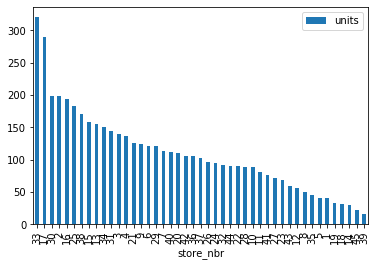

In [87]:
store_sales.groupby('store_nbr').mean().sort_values(by='units', ascending=False).plot(kind='bar')

Stores 33 and 17 sell the most by far, with around 300 items per day.

Now let's check the top 10 items in terms of sales, since this will present difficulties in terms of supply chain and logistics. 

Text(0.5, 1.0, 'Daily average sales for top 50 items')

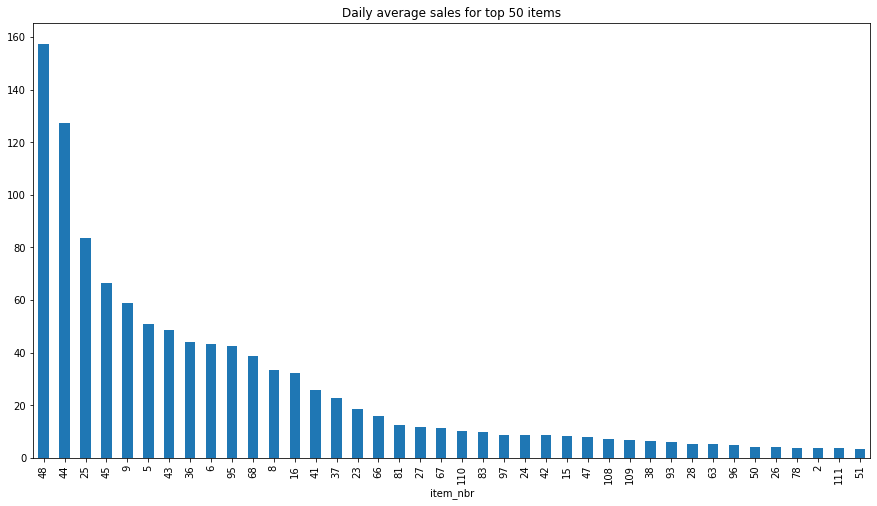

In [116]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sales_df.groupby('item_nbr')['units'].mean().sort_values(ascending=False).iloc[0:40].plot(kind='bar', ax=ax)
ax.set_title('Daily average sales for top 50 items')

### Explore weather data 

In [47]:
#Get number of stores
stores_stations = pd.read_sql_query("""select * FROM RetailWeather.key ORDER BY store_nbr;""", conn)

In [50]:
stores_stations.store_nbr.nunique(), stores_stations.station_nbr.nunique()

(45, 20)

So we have 45 stores, each with one of the 20 weather stations (`station_nbr`) assigned to it, which has recorded the weather conditions for that specific station during 3 years. Now we are going to extract the weather data:

In [45]:
#Get number of stations
weather_df = pd.read_sql_query("""select * from weather;""", conn) 

In [46]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaT,NaT,RA FZFG BR,NaN,0.05,29.78,29.92,3.6,20.0,4.6
1,1,2012-01-02,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,NaT,NaT,,NaN,0.01,29.44,29.62,9.8,24.0,10.3
2,1,2012-01-03,32.0,11.0,22.0,NaN,4.0,18.0,43.0,0.0,NaT,NaT,,NaN,0.00,29.67,29.87,10.8,31.0,11.6
3,1,2012-01-04,28.0,9.0,19.0,NaN,-1.0,14.0,46.0,0.0,NaT,NaT,,NaN,0.00,29.86,30.03,6.3,27.0,8.3
4,1,2012-01-05,38.0,25.0,32.0,NaN,13.0,25.0,33.0,0.0,NaT,NaT,,NaN,0.00,29.67,29.84,6.9,25.0,7.8


Check if all stations are inside our `stores_stations` data. 

In [57]:
weather_df.station_nbr.unique() in stores_stations.station_nbr.unique()

True

Now that we have the weather conditions for every station, let's take a look at how the weather changes accross the city. 

In [60]:
weather_df.shape

(20517, 20)

Check continuity for all stations to review similarities/differences between stations 

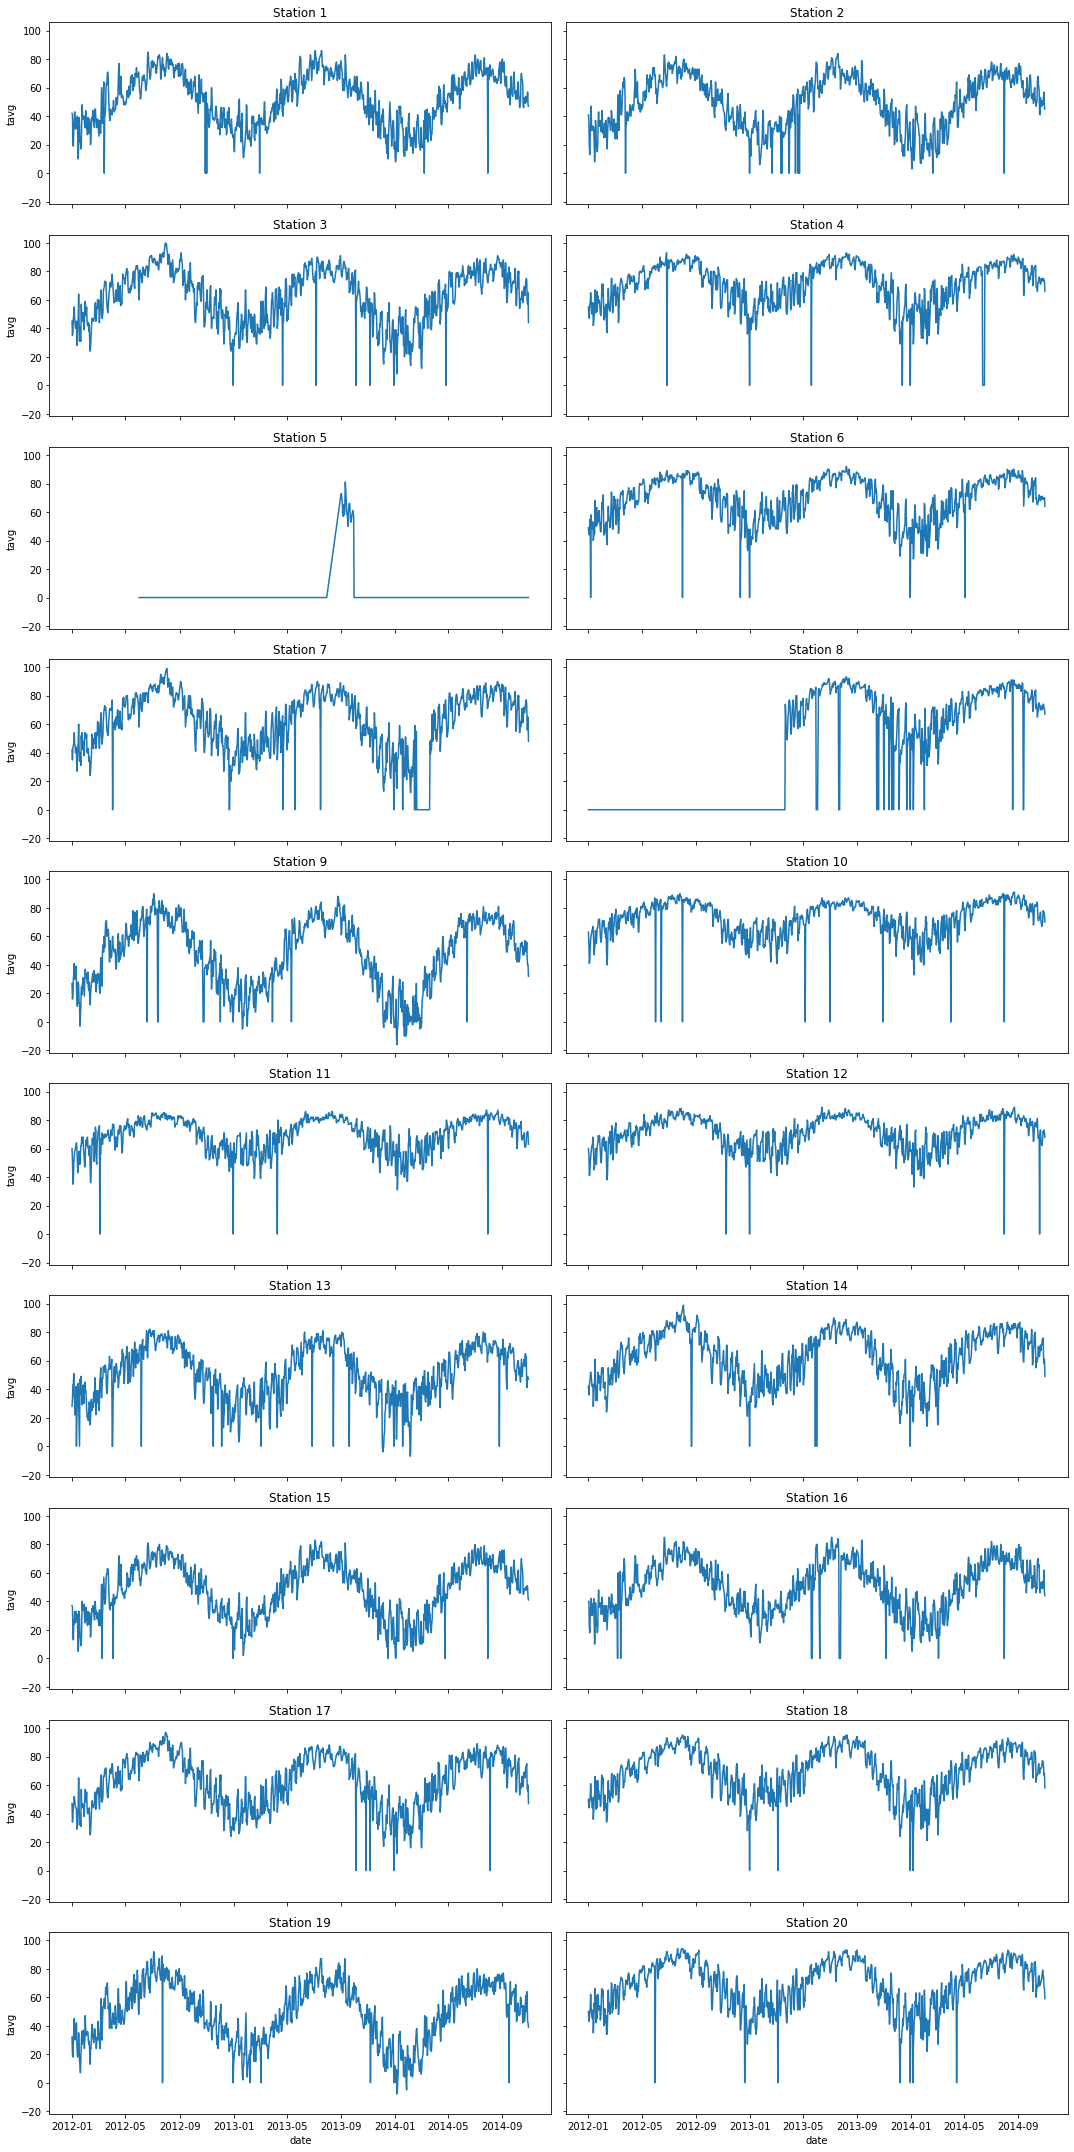

In [77]:
fig, axes = plt.subplots(10,2, figsize=(15,30), sharex=True, sharey=True)

tavg_by_stat = weather_df.groupby(['date', 'station_nbr'])[['tavg']].sum().reset_index()

for ax, station in zip(axes.flat, weather_df.station_nbr.unique()):
    sns.lineplot(data=tavg_by_stat.loc[tavg_by_stat.station_nbr == station], x='date', y='tavg', ax=ax)
    ax.set_title(f'Station {station}')

fig.tight_layout()

Some observations from this plot:

* We have significant null values in every station, we will have to work on those later.
* Station 5 and station 8 will be ommited from the analysis since hey are incomplete and mostly null.
* We can see that the behavior across stations is not constant at all, not even at a large scale, hence, we will will not be able to aggregate the data in order to generate predictions.
* One option, is to generalize the model across weather conditions, in order to scale our data for model building. This is to say, we can treat each day at each station as a data point that results in a count of sales for each store.